## Importado as bibliotecas

In [1]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import Image
import scorecardpy as sc
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)
diretorio=os.getcwd()
diretorio

'/Users/igoracmorais/igor/4labs/consulting/score_credito/explicando_scorecard'

## Abrindo os dados

In [2]:
dataset = pd.read_csv('german_credit_data2.csv',index_col=0)
print(dataset.shape)
dataset.head(2)

(1000, 10)


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,default
0,67,male,2,own,little,little,1169,6,radio/TV,yes
1,22,female,2,own,little,moderate,5951,48,radio/TV,no


## Parte 2. Usando o pacote Scorecardpy
Esse pacote do python faz todas as contas que foram ilustradas no notebook anterior (WOE e IV) e ainda permite criar visualizações e demais comandos para analise dos resultados. Ele é derivado do pacote scorecard do R.

Veja que no nosso banco de dados a variável dependente ainda está como "string". Antes de seguir devemos converter em categorica onde, para fins de aplicação do modelo de previsão de probabilidade, o cliente que entrou em default="yes" terá o valor 1.

In [3]:
df=dataset.copy()
df['default']=np.where(df['default']=='yes',1,0)

Antes de seguir vamos entender quais sao os passos que queremos percorrer:  <br>
1. encontrar o IV e selecionar as variaveis relevantes. Fazemos isso usando duas funções.
2. encontrar o woe para cada variavel e caracteristicas e salvar em um novo banco de dados.

### 1. Encontrar o IV e selecionar as variaveis relevantes
Como vimos no notebook 3, o IV é uma estatística interessante que pode ser usadaa para selecionar variaveis de interesse de acordo com seu grau de explicação. Isso pode ser feito no pacote scorecardpy a partir de duas funções:

#### 1.1. iv(dt, y, x=None, positive='bad|1', order=True)
Essa função calcula o IV para as diferentes variaveis independentes "x". Se tivermos alguma classe em uma variavel com 0 frequência, a fórmula substitui esse valor por 0.99 para garantir que o calculo seja feito. A seguir a descrição de cada parâmetro:<br>
1. dt: banco de dados com as variaveis x e y
2. y: nome da variavel dependente
3. x: nome das variaveis x. Deixando "None", será calculado para todas menos y
4. positive: o valor da classe considerada como positiva. Como default "bad=1"
5. order: deixando True retorna o valor do IV de forma descendente.

In [4]:
IV_=sc.iv(dt=df, y='default', x=None, positive='bad|1', order=True)
IV_

,variable,info_value
0,Age,0.177582
6,Duration,0.119746
4,Credit amount,0.050364
8,Saving accounts,0.035196
3,Purpose,0.014360
1,Housing,0.003426
2,Job,0.003091
5,Checking account,0.001468
7,Sex,0.000877


Pelos resultados a variavel mais importante é "Age" e, considerando a "regra de bolso" para escolha das variaveis pelo IV, temos apenas 2 com fraca relacao e as demais com muito fraca. Para fins de ilustração da aplicação do scorecard, vamos seguir com todas as variaveis.

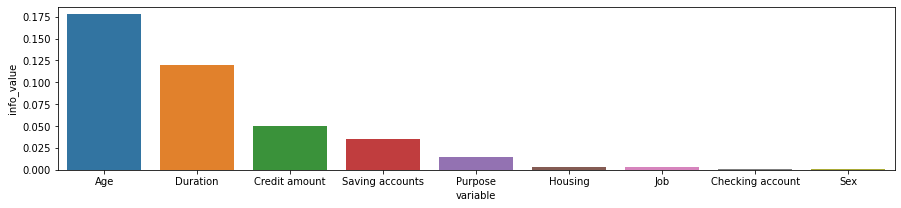

In [5]:
plt.figure(figsize=(15,3))
sns.barplot(y='info_value',x='variable',data=IV_);

#### 1.2.  var_filter
Essa função filtra as variaveis importantes com base em uma condição especificada como o IV, taxa de missing ou taxa de valor identico. Sua função:  <br>
<br>
var_filter(dt, y, x=None, iv_limit=0.02, missing_limit=0.95, identical_limit=0.95, var_rm=None, var_kp=None, return_rm_reason=False, positive='bad|1'):

1. dt: banco de dados com as variaveis x e y
2. y: nome da variavel y (dependente)
3. x: nome das variaveis x. Deixando "None", será calculado para todas menos y
4. iv_limit: limite da estatistica IV que define qual variavel selecionar. Default=0.02
5. missing_limit: taxa de corte dos valores perdidos. Seleciona variaveis com um % menor que essa taxa. default=0.95
6. identical_limit: taxa de valores identicos. Seleciona variaveis que possuem uma tasa de valores identicos menor que o limite. default=0.95
7. var_rm: nome para as variaveis removidas. Default=Null
8. var_kp: nome para as variaveis mantidas. Default=Null
9. return_rm_reason: razao para eliminar. Default=False
10. positive: o valor da classe considerada como positiva. Como default "bad=1"

Vamos aplicar essa funcao a luz dos resultados do IV encontrados anteriormente. Sabemos dali quais sao as variaveis que podem ser selecionadas para um iv>0.02. Vamos conferir se o resultado bate....

In [6]:
df2=sc.var_filter(df,y='default',iv_limit=0.02,positive='bad|1')
print(df2.columns)
df2.head(2)

[INFO] filtering variables ...
Index(['Age', 'Credit amount', 'Duration', 'Saving accounts', 'default'], dtype='object')


,Age,Credit amount,Duration,Saving accounts,default
0,67,1169,6,little,1
1,22,5951,48,little,0


Veja que foram selecionadas as mesmas 4 variaveis de antes e retornado um banco de dados com essas variaveis selecionadas mais a variavel dependente.

### 2. Encontrar o WOE
O calculo do Woe é relativamente simples. O desafio aqui seria encontrar qual o intervalo ótimo (binning) para cada variavel. Nesse caso, o pacote oferece algumas opções interessantes de funções de calculo, ilustração, analise e estimativa:  <br>
1. woebin: encontra o intervalo ótimo (binning) e retorna esses intervalos (breakpoints)  para uso posterior.  O default é considerar no numerador da distribuição os mal pagadores/bons pagadores. Caso queira o inverso, mude o parametro positive=0;
2. woebin_plot: apos gerar os intervalos (binning) usando o woebin, use essa função para criar graficos para cada intervalo encontrado. útil para visualização apenas.
3. woebin_adj: muitas vezes pode acontecer de se querer escolher os intervalos manualmente. Isso pode ser feito usando essa função, que recebe como input os intervalos encontrados primeiro com o woebin e, depois de corrigido, retorna uma nova lista de breakpoints. Use apenas se quiser criar os intervalos (binning) manualmente.
4. woebin_ply: Uma vez que encontramos os intervalos (binning), podemos aplicar esses nos dados originais para converter os mesmos nos respectivos woe. Usa como input os intervalos encontrados na função woebin. <br>
<br>
A seguir vamos explicar cada uma dessas quatro formulas:

#### 2.1. Woebin - encontrando os intervalos ótimos

woebin(dt, y, x=None, var_skip=None, breaks_list=None, special_values=None,stop_limit=0.1, count_distr_limit=0.05, bin_num_limit=8, min_perc_fine_bin=0.02, min_perc_coarse_bin=0.05, max_num_bin=8,positive="bad|1", no_cores=None, print_step=0, method="tree", ignore_const_cols=True, ignore_datetime_cols=True,check_cate_num=True, replace_blank=True, save_breaks_list=None)

1. dt: banco de dados com as variaveis x e y
2. y: nome da variavel y (dependente)
3. x: nome das variaveis x. Deixando "None", será calculado para todas menos y
4. var_skip: Nome das variaveis que não serao avaliadas para criar intervalos. Default= None.
5. breaks_list: lista dos pontos de quebra dos intervalos, caso se queira fornecer. Default = None. 
6.  special_values: valores especiais separados do binning. Default = None.
7. count_distr_limit: Percentual minimo de dados na classe. Escolha entre 0.01-0.2. Default = 0.05 (5% como aponta na teoria).
8. stop_limit: ponto de interrupção do processo de criar intervalos com base no valor minimo de "chi-square < 'qchisq(1-stoplimit, 1)". Default = 0.1.
9. bin_num_limit: Integer. Numero maximo de intervalos. Default=8.
10. positive: o valor da classe considerada como positiva. Como default "bad=1".
11. no_cores: Numero de CPU usada.
12. print_step: imprime cada variavel em cada passo.Default = 1 para mostrar.
13. method: Método usado para encontar o intervalo otimo: default = "tree"; ou "chimerge".
14. ignore_const_cols: Ignora colunas com valores constantes. Defaults = True.
15. ignore_datetime_cols: Ignora colunas de datetime. Defaults = True.
16. check_cate_num: Verifica se a quantidade de valores unicos na coluna>50. Se o valor de unique() é elevado, o processo de criar intervalos fica lento. Defaults = True.
17. replace_blank: Substitui valores em branco por "None". Defaults = True.
18. save_breaks_list: Nome do arquivo para salvar a "breaks_list". Default = None.

No exemplo abaixo aplicamos a função para o banco de dados deixando todos os demais parametros como default. Veja que não foi considerado o resultado do IV para selecionar as variaveis relevantes. Aplicamos a todas.

In [7]:
intervalos=sc.woebin(dt=df, y='default',method="tree",save_breaks_list='woebin')
intervalos

[INFO] creating woe binning ...
[INFO] The breaks_list is saved as woebin_20210714_220739.py


{'Age':   variable          bin  count  count_distr  good  bad   badprob       woe  \
 0      Age  [-inf,23.0)     57        0.057    35   22  0.385965  0.416552   
 1      Age  [23.0,30.0)    314        0.314   229   85  0.270701 -0.110213   
 2      Age  [30.0,32.0)     78        0.078    49   29  0.371795  0.356334   
 3      Age  [32.0,40.0)    252        0.252   177   75  0.297619  0.022196   
 4      Age  [40.0,44.0)     81        0.081    64   17  0.209877 -0.444812   
 5      Age  [44.0,48.0)     67        0.067    47   20  0.298507  0.026443   
 6      Age  [48.0,54.0)     62        0.062    39   23  0.370968  0.352791   
 7      Age   [54.0,inf)     89        0.089    67   22  0.247191 -0.232792   
 
      bin_iv  total_iv breaks  is_special_values  
 0  0.010656  0.052397   23.0              False  
 1  0.003725  0.052397   30.0              False  
 2  0.010572  0.052397   32.0              False  
 3  0.000125  0.052397   40.0              False  
 4  0.014458  0.052397   

O resultado encontrado nada mais é que um dicionario com os intervalos otimos para cada variavel. Alem disso, temos as informações desses intervalos, como numero de dados, woe e iv. Podemos analisar graficamente esses resultados de forma simples, usando a função "woebin_plot"....

In [8]:
intervalos['Housing']

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,Housing,free,108,0.108,80,28,0.259259,-0.168964,0.002972,0.003426,free,False
1,Housing,own,713,0.713,502,211,0.295933,0.014116,0.000142,0.003426,own,False
2,Housing,rent,179,0.179,125,54,0.301676,0.041528,0.000311,0.003426,rent,False


#### 2.2. Fazendo o grafico dos intervalos (bins) com iv

woebin_plot(bins, x=None, title=None, show_iv=True):

1. bins: resultados gerados pelo woebin.
2. x: nome das variaveis x. Deixando "None", será calculado para todas menos y.
3. title: Texto adicionado ao grafico. Default = None.
4. show_iv: Mostra o resultado do IV no grafico. Default = True.

{'Age': <Figure size 432x288 with 2 Axes>,
 'Housing': <Figure size 432x288 with 2 Axes>,
 'Job': <Figure size 432x288 with 2 Axes>,
 'Purpose': <Figure size 432x288 with 2 Axes>,
 'Credit amount': <Figure size 432x288 with 2 Axes>,
 'Checking account': <Figure size 432x288 with 2 Axes>,
 'Duration': <Figure size 432x288 with 2 Axes>,
 'Sex': <Figure size 432x288 with 2 Axes>,
 'Saving accounts': <Figure size 432x288 with 2 Axes>}

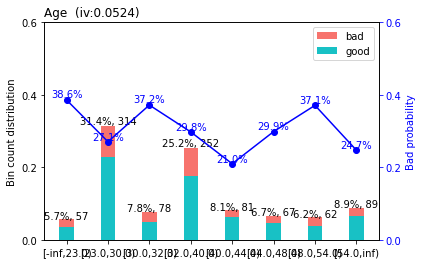

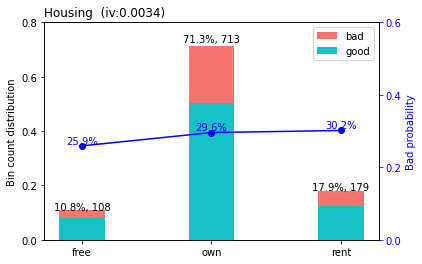

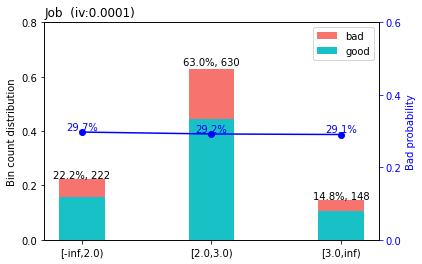

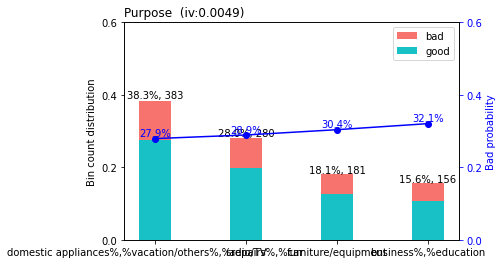

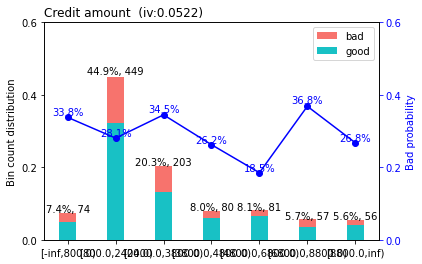

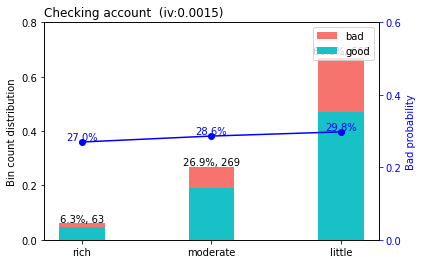

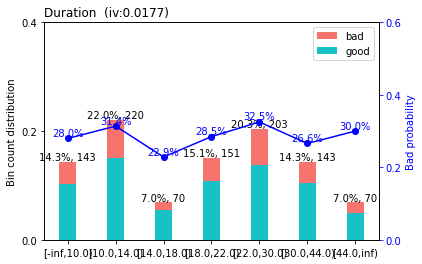

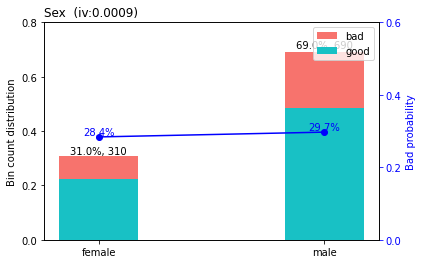

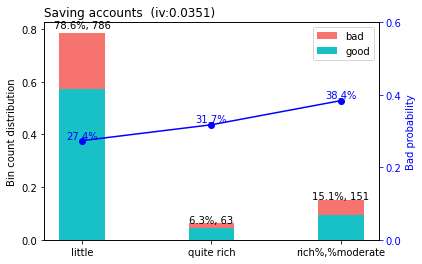

In [9]:
sc.woebin_plot(intervalos, x=None, title=None, show_iv=True)

Caso não se esteja satisfeito com os resultados dos intervalos encontrados automaticamente pela função woebin e tenha interesse em fazer isso de forma manual então, a função ideal para isso seria a "woebin_adj". Aqui temos apenas que inserir os intervalos gerados pelo woebin e fazer a mudança manualmente.

#### 2.3. Ajustando os intervalos manualmente

woebin_adj(dt, y, bins, adj_all_var=False, special_values=None, method="tree", save_breaks_list=None, count_distr_limit=0.05)

1. dt: Banco de dados com as variaveis x e y.
2. y: Nome da variável y.
3. bins: Uma lista, ou o banco de dados das informações geradas pelo woebin
4. adj_all_var: Mostrar ou não as variaveis monotônicas. Default = True
5. special_values: Caso tenha valores especiais, especificar. Default = None.
6. method: Metodo de escolha dos intervalos: default="tree" ou "chimerge". 
7. save_breaks_list: Arquivo para salvar a lista dos intervalos. Default = None.
8. count_distr_limit: Percentual minimo de dados na classe. Escolha entre 0.01-0.2. Default = 0.05 (5% como aponta na teoria).

#### 2.4. Convertendo os dados em valores de woe

Esse passo pega como input a lista de intervalos (bins) gerada anteriormente, seja pela função woebin ou woebin_adj e aplica a mesma no banco de dados para converter os dados originais em valores woe. Esse é o último passo preparatório dos dados antes de inserir os dados em um modelo que irá determinar o scorecard.

woebin_ply(dt, bins, print_step=0, replace_blank=True)

1.  dt: Banco de dados original.
2. bins: Intervalos gerados pelo woebin.
3. no_cores: Número de CPU usadas.
4. print_step: Se vai ou não imprimir os resultados. Default = 1. Se print_step=0 nenhuma mensagem é impressa.
5. replace_blank: Substitui valore nulos por None. Defaults = True.

Para ilustrar, pegamos os intervalos gerados pela função woebin acima e inserimos na função woebin_ply para modificar o banco de dados original e salvamos o mesmo com outro nome....

In [10]:
df_woe=sc.woebin_ply(dt=df, bins=intervalos, print_step=0, replace_blank=True)
df_woe.head(4)

[INFO] converting into woe values ...


,default,Age_woe,Housing_woe,Job_woe,Purpose_woe,Credit amount_woe,Checking account_woe,Duration_woe,Sex_woe,Saving accounts_woe
0,1,-0.232792,0.014116,-0.004525,-0.017998,-0.060512,0.023560,-0.064991,0.019719,-0.095893
1,0,0.416552,0.014116,-0.004525,-0.017998,-0.600746,-0.032832,0.033560,-0.044483,-0.095893
2,1,0.352791,0.014116,0.020657,0.129442,-0.060512,0.023560,0.097685,0.019719,-0.095893
3,0,0.026443,-0.168964,-0.004525,0.051909,0.341862,0.023560,-0.135516,0.019719,-0.095893


Agora temos um banco de dados pronto para ser usado em um modelo que tenha a capacidade de  poder prever qual seria o score de um candidato. Faremos isso no notebook 4. Portanto, salvamos esse banco de dados para usar no próximo notebook.

In [11]:
df_woe.to_csv('woe_to_model.csv')